In [1]:
%load_ext autoreload
%autoreload 2

# Рекомендуем популярные товары

Вы - разработчик рекомендательной системы в сервисе по заказу продуктов "Хлеб и корочка". Пользователи заказывают продукты питания на вашем сайте. Заходя на главную страницу, они видят 20 рекомендуемых товаров и выбирают понравившиеся. Мы изучили их предпочтения и выяснили, что пользователи часто выбирают популярные товары. У нас нет информации о товарах и пользователях, кроме их идентификаторов (id). Вам нужно обучить рекомендательную модель, максимизирующую количество купленных товаров. У вас нет исторических данных, но доступен симулятор, генерирующий отклики пользователей на рекомендации, который поможет получить данные в интерактивном режиме.


### Пользователи
1000 анонимных пользователей

### Товары
100 товаров повседневного спроса

### Модель отклика пользователя на товары
Пользователь с большей вероятностью выбирают часто покупаемые товары. Пользователи покупают товары только из рекомендаций, по одной штуке и могут покупать те же самые товары при повторном посещении сервиса.

### Задача
Построить рекомендательную систему, которая обеспечит наибольшее количество покупок товаров на пользователя

### Доступные данные
Пользователи будут реагировать на ваши рекомендации в интерактивном режиме. Вы получаете список пользователей, для каждого из которых нужно подготовить по 20 рекомендаций. Модель отклика симулятора генерирует отклики на рекомендации, которые вы можете использовать для обучения рекомендательной системы. Мы не "прячем" от вас модель отклика, но просим не использовать ее и данные, которые она использует, в своем решении. В данной задаче вы не обладаете никакой информацией о пользователях и товарах, кроме их идентификаторов.

## Симулятор
Симуляторы для рекомендательных систем - популярная тема для исследований и разработки в последние годы. Например, свои симуляторы разрабатывались в таких компаниях как Criteo, Google, Netflix, Baidu. Симуляторы позволяют: сохранять анонимность реальных пользователей, обучать модели и сравнивать их offline, изучать поведение и метрики рекомендательных систем в долгосрочной перспективе.
В компаниях экосистемы Сбера есть довольно много рекомендательных задач и данных. __Симулятор Sim4Rec разработан Сбером для моделирования взаимодействия пользователей с рекомендательными системами.__ Ниже представлена схема цикла симуляции для обучения и тестирования рекомендательных систем в нашем симуляторе.

<img src="./images/simulation_cycle.png">

Для симуляции могут использоваться реальные и синтетические профили (признаки/фичи) пользователей (users) и товаров (items).
Использование синтетических данных позволяет сохранить приватность реальных клиентов и смоделировать более разнообразные ситуации (например, сгененрировать больше пользователей из какой-то группы/кластера).

(1) После генерации популяции товаров и пользователей можно запускать цикл симуляции.
На первом этапе мы выбираем пользователей, который будут взаимодействовать с рекомендательной системой на данной итерации. Это могут быть все пользователи или какая-то их часть.

(2) Затем мы можем выбрать товары, которые будут доступны для пользователей. В базовом варианте, который и будет реализован в наших заданиях, все товары доступны для всех пользователей. Но в реальной жизни какие-то товары могут отсутствовать, могут быть недоступны пользователям из-за ограничений, или же наоборот, мы может формировать персональные предложения для пользователей на этом этапе. 

(3) Следом начинается работа рекомендательная система, которая генерирует для пользователей рекомендуемые товары. Мы будем рассматривать задачу генерации top-k наиболее релевантных товаров для пользователя.

(4) Рекомендации возвращаются в симулятор, который генерируют отклик пользователей на увиденные рекомендации. Это могут быть лайки, добавление в избранное, факт покупки, время просмотра. В реальной задаче пользователь может давать отклики разных типов, мы будем рассматривать только один тип отклика (например, покупку).

(5) Рекомендательная система обновляется с учетом информации об откликах, полученных на текущей итерации цикла симуляции.

Ваша задача - написать алгоритм рекомендательной системы, который даст наибольшее количество положительных откликов на пользователя. Алгоримтм будет обучаться в цикле симуляции N итераций, а на N + 1 итерации будет оцениваться качество рекомендаций в метрике Precision@K (среднее число кликов из top-K рекомендаций у пользователя).

## Симулятор и большие данные

В экосистеме Сбера есть сервисы, у которых большое количество клиентов, и которые предлагают большое количество товаров. Часто для работы с такими объемами данных используются решения на spark. Симулятор sim4rec написан на pyspark и позволяет использовать преимущества spark-а для работы с большими данными и простоту и ds-инструмены python.

Ваша рекомендательная модель может быть написана на чем угодно, главное конвертировать результаты ее работы в pyspark в нужном формате перед передачей их в симулятор. Если вы не работали с pyspark ранее, вам поможет наш [tutorial](./pyspark_tutorial.ipynb), выложенный в директории с ноутбуками.

## Импорты и настройки

In [2]:
import os
import sys
os.environ["PYSPARK_PYTHON"]=sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"]=sys.executable

In [3]:
import random
import time

import pandas as pd
import numpy as np

import pyspark.sql.functions as sf
from pyspark import SparkConf
from pyspark.ml import PipelineModel
from pyspark.sql import SparkSession
from surprise import SVD, Dataset, Reader, SVDpp, KNNBaseline, SlopeOne, NMF


from replay.models import UCB
from replay.session_handler import State
from replay.utils import get_top_k_recs

# укажите путь к tmp-папке spark и директории с чекпоинтами симулятора.
SPARK_LOCAL_DIR = './tmp/task_1'
CHECKPOINT_DIR = './tmp/task_1_checkpoints'

In [4]:
from simulator.modules import RealDataGenerator
from simulator.modules import Simulator

from helpers.task_1_model import TaskOneResponse
from helpers.utils import plot_metric, calc_metric

In [5]:
%%bash -s "$CHECKPOINT_DIR" "$SPARK_LOCAL_DIR"
# симулятор записывает историю взаимодействия пользователей с рекомендательной системой на диск
# чтобы перезапустить цикл симуляции или начать новый, очистите директорию или используйте другую в качестве CHECKPOINT_DIR
rm -rf $1 $2

In [6]:
# если вы не работали со Spark ранее, оставьте настройки сессии неизменными
NUM_THREADS = 4

spark = SparkSession.builder\
    .appName('simulator')\
    .master(f'local[{NUM_THREADS}]')\
    .config('spark.sql.shuffle.partitions', f'{NUM_THREADS * 3}')\
    .config('spark.default.parallelism', f'{NUM_THREADS * 3}')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

State(spark)
spark.sparkContext.setLogLevel('ERROR')

22/12/03 10:00:42 WARN Utils: Your hostname, cl1nr5sb14mq6gk2g9m8-ybuc resolves to a loopback address: 127.0.1.1; using 10.129.0.36 instead (on interface eth0)
22/12/03 10:00:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/12/03 10:00:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/12/03 10:00:42 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/12/03 10:00:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [7]:
NUM_USERS = 1000
NUM_ITEMS = 100
# число рекомендаций, генерируемых рекомендательной системой на пользователя на одной итерации
K = 20
# количество итераций
NUM_ITER = 50
SEED = 1234

## Исходные данные

В нашем распоряжении есть id пользователей и товаров.

In [8]:
users = spark.createDataFrame([[x] for x in range(NUM_USERS)], schema=["user_idx"])
items = spark.createDataFrame([[x] for x in range(NUM_ITEMS)], schema=["item_idx"])
items.show(2)

+--------+
|item_idx|
+--------+
|       0|
|       1|
+--------+
only showing top 2 rows



Симулятор позволяет использовать реальные данные о пользователях и товарах (фичи) и синтетические (сгенерированные на основе реальных). 
В этой задаче в нашем распоряжении есть только id пользователей и товаров, генерация синтетических данных в этой задаче не актуальна. Поэтому мы будем использовать реальные данные и сэмплировать из них с использованием RealDataGenerator.

In [9]:
item_generator = RealDataGenerator(label='items_real', seed=SEED)
user_generator = RealDataGenerator(label='users_real', seed=SEED)

# передадим популяции пользователей и айтемов
item_generator.fit(items)
user_generator.fit(users)

# будем использовать всех пользователей и айтемы из популяции
item_generator.generate(NUM_ITEMS)
user_generator.generate(NUM_USERS)

DataFrame[user_idx: bigint]

# Пройдем одну итерацию цикла симуляции поэтапно

## (1) Выбор пользователей

In [10]:
# генератор позволяет сэмплировать выбранную долю пользователей от общего количества. 
# Из-за особенностей spark это количество не будет точным. Ниже будет выбрано около 10 пользователей.
user_generator.sample(0.01).count()

7

## (2) Выбор товаров
В цикле симуляции вам будут доступны все 100 айтемов на каждой итерации. Вы можете самостоятельно ограничить количество доступных айтемов при желании.

## (3) Инициализация рекомендательной модели

Ваша задача - написать код рекомендательной модели, инициализировать модель здесь и использовать в цикле обучения ниже.

Модель должна принимать на вход список пользователей и товаров и возвращать для каждого пользователя top-K самых релевантных для него товаров в виде датафрейма в формате <user_idx int, item_idx int, relevance double>. 

Модель может принимать на вход и использовать дополнительную информацию: предыдущую историю взаимодействия выбранных пользователей с рекомендательной системой и признаки пользователей и айтемов (в этой задаче их нет).

Мы предлагаем вам baseline рекомендательной системы из нашей библиотеки RePlay. 

Модель UCB - неперсонализированный алгоритм, оценивающий релевантность товаров по верхней границе доверительного интервала. 
В момент построения рекомендаций модель сэмплирует top-K айтемов для каждого пользователя с вероятностью, пропорциональной рассчитанным релевантностям. Узнать больше об алгоритме UCB и посмотреть пример реализации можно [здесь](https://medium.com/analytics-vidhya/multi-armed-bandit-analysis-of-upper-confidence-bound-algorithm-4b84be516047).

### Baseline модель

In [11]:
model = UCB(sample=True, seed=SEED)
# Модель из RePlay нужно обучить на исторических данных, прежде чем можно будет обучать ее дальше в цикле 
# Обойдем это ограничение, представив, что в истории было одно взаимодействие
model.fit(log=users.limit(1).crossJoin(items.limit(1)).withColumn("relevance", sf.lit(1)))

Посмотрим, как выглядят предсказания модели для 2 пользователей: у нас есть рекомендации для обоих пользователей и для каждого пользователя вернулось по 3 товара.

In [12]:
pred = model.predict(log=None, users=users.limit(2), items=items, k=3)
pred.show(6)

+--------+--------+---------+
|user_idx|item_idx|relevance|
+--------+--------+---------+
|       0|      53|     0.01|
|       0|      62|     0.01|
|       0|      79|     0.01|
|       1|      55|     0.01|
|       1|      57|     0.01|
|       1|       9|     0.01|
+--------+--------+---------+



## (4) Модель отклика

Модель отклика пользователей на товары в этой задаче является очень простой. Отклик является бинарным, отклик равный 1 означает факт покупки. Отклик не является детерминированным, вероятность положительного отклика пропорциональна популярности товара в прошлом.  Вероятность отклика пользователя не меняется со временем, но сам факт положительного отклика на данной итерации - случайная величина. 

Модель отклика принимает датафрейм с колонками <user_idx, item_idx, relevance>, где relevance - оценка релевантности рекомендательной системой и возвращает датафрейм с обязательными колонками <user_idx, item_idx, relevance, response>, добавляя к исходным данным столбец с откликами (response). Если в датафреме, поданном на вход в модель отклика, были признаки, они также будут возвращены.

In [13]:
popularity_model = TaskOneResponse(seed=SEED)

Посмотрим на примере, как формируется отклик для пары пользователь-товар

In [14]:
test_response = popularity_model.transform(pred)
test_response.show()

+--------+--------+---------+--------+
|user_idx|item_idx|relevance|response|
+--------+--------+---------+--------+
|       0|      53|     0.01|       0|
|       0|      62|     0.01|       0|
|       0|      79|     0.01|       0|
|       1|      55|     0.01|       0|
|       1|      57|     0.01|       0|
|       1|       9|     0.01|       0|
+--------+--------+---------+--------+



## (5) Дообучение рекомендательной модели

После получения откликов на рекомендации можно дообучать рекомендательную модель. В примере выше бинарный отклик находится в колонке response, а модель принимает на вход историю взамодействия (log) в виде датафрейма со столбцами <user_idx, item_idx, relevance>. Т.е. нам нужно будет выбрать нужные столбцы из истории и переименовать response в relevance. Обратите внимание, что если ваша модель использует признаки, они могут быть переданы в модель как отдельные параметры при инициализации или быть добавлены в log в виде отдельных колонок. 
Вы можете реализовать дообучение модели на новых данных на каждой итерации или полностью переобучать модель на всех данных, имеющихся в логе симулятора `sim.log`. Здесь будет пример с дообучением, а в цикле ниже будем использовать переобучение на всех данных.

In [15]:
new_log = test_response.drop("relevance").withColumnRenamed("response", "relevance")
new_log.show()

+--------+--------+---------+
|user_idx|item_idx|relevance|
+--------+--------+---------+
|       0|      53|        0|
|       0|      62|        0|
|       0|      79|        0|
|       1|      55|        0|
|       1|      57|        0|
|       1|       9|        0|
+--------+--------+---------+



In [16]:
# вы можете реализовать дообучение модели на новых данных или переобучение на всех данных, накопленных в ходе одного цикла симуляции
model.refit(log=test_response.drop("relevance").withColumnRenamed("response", "relevance"))

## (6) Оценка качества рекомендаций

Оценка качества будет выполняться по среднему числу положительных откликов на пользователя. Если ваша модель делает exploration, ее качество может быть ниже, чем будет в реальности. В таком случае, чтобы оценить реальный прогресс модели, вы можете сгенерировать рекомендации и отклики повторно, без exploration, но эти данные допустимо использовать только для оценки метрики, а не для дообучения.

In [17]:
calc_metric(test_response)

0.0

# Обучение модели в симуляторе

Перейдем непосредственно к циклу симуляции. Инициализируем симулятор и все нужные для симуляции модели. Обратите внимание, что если вы захотите перезапустить эксперимент, нужно будет выбрать другую папку для сохранения данных `data_dir` или удалить с диска результаты предыдущего эксперимента. Либо вы можете продолжить эксперимент с новой итерации (например, последней была выполнена 10 итерация, значит цикл нужно продолжить с 11-ой). 

Запустите ячейки ниже последовательно, чтобы начать новый эксперимент.

In [18]:
%%bash -s "$CHECKPOINT_DIR"
# симулятор записывает историю взаимодействия пользователей с рекомендательной системой на диск
# чтобы перезапустить цикл симуляции или начать новый, очистите директорию или используйте другую в качестве CHECKPOINT_DIR
rm -rf $1

## Повторно инциализируем компоненты симулятора

In [19]:
user_generator.initSeedSequence(SEED)
item_generator.initSeedSequence(SEED)

sim = Simulator(
    user_gen=user_generator,
    item_gen=item_generator,
    data_dir=f'{CHECKPOINT_DIR}/pipeline',
    user_key_col='user_idx',
    item_key_col='item_idx',
    spark_session=spark
)

## Инициализация вашей рекомендательной модели

In [21]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
class SVDRL:
    def __init__(self):
        #self.model = SVDpp(n_factors=20, n_epochs=20)
        self.models = [(KNNBaseline(k=40), 0.5), (SVDpp(n_factors=20, n_epochs=20), 0.3), (SVD(), 0.2)]
        #self.model = NMF(n_factors=20, n_epochs=20)
        self.ucb = UCB(sample=True, seed=SEED)
        self.scaler = MinMaxScaler()
        
    def fit(self, log=None):
        self.ucb.fit(log)
        log = log.toPandas()
        reader = Reader(rating_scale=(0, 1))
        data = Dataset.load_from_df(log[["user_idx", "item_idx", "relevance"]], reader)
        trainset = data.build_full_trainset()
        for e in range(3):
            self.models[e][0].fit(trainset)
        #self.model.fit(trainset)
        
    def predict(self, log=None, k=None, users=None, items=None, filter_seen_items=None):
        result = []
        recs = self.ucb.predict(
            log=log,
            k=items.count(),
            users=users,
            items=items,
            filter_seen_items=False
        ).cache()
        recs = recs.toPandas().sort_values(by=['user_idx', 'item_idx'])
        recs['relevance'] = self.scaler.fit_transform(np.array(recs['relevance']).reshape(-1, 1)).reshape(-1)
        it_ = 0
        for u in sorted(users.toPandas()['user_idx']):
            buffer = []
            for i in sorted(items.toPandas()['item_idx']):
                score = sum([model[0].predict(u, i).est * model[1] for model in self.models]) + recs.iloc[it_]['relevance'] * 0.1
                it_ += 1
                buffer.append((u, i, score))
            buffer.sort(key=lambda x: -x[2])
            result.extend(buffer[:k])
        return spark.createDataFrame(pd.DataFrame(result, columns=['user_idx', 'item_idx', 'relevance']))

In [22]:
### YOUR CODE HERE: инициализация модели
model = SVDRL()
model.fit(log=users.limit(1).crossJoin(items.limit(1)).withColumn("relevance", sf.lit(1)))
###

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


### Проверка формата рекомендаций моделью

In [23]:
### YOUR CODE HERE: получите K уникальных рекомендаций для 10 пользователей 
pred = model.predict(log=None, users=users.limit(10), items=items, k=K)
###

# проверьте правильность формирования рекомендаций
assert pred.columns == ["user_idx", "item_idx", "relevance"]
assert pred.groupBy('user_idx').agg(sf.countDistinct("item_idx").alias("num_items")).filter(sf.col("num_items") == sf.lit(K)).count() == 10
assert pred.groupBy('user_idx').agg(sf.count("item_idx").alias("num_items")).filter(sf.col("num_items") == sf.lit(K)).count() == 10

## Инициализация функции отклика

In [24]:
popularity_model = TaskOneResponse(seed=SEED)

## Цикл симуляции

In [25]:
# если вы запустили цикл симуляции и остановили его до окончания выполнения, выполните unpersist датафреймов
# current_users.unpersist()
# if log is not None:
#     log.unpersist()
# recs.unpersist()
# true_resp.unpersist()
# train_log..unpersist()

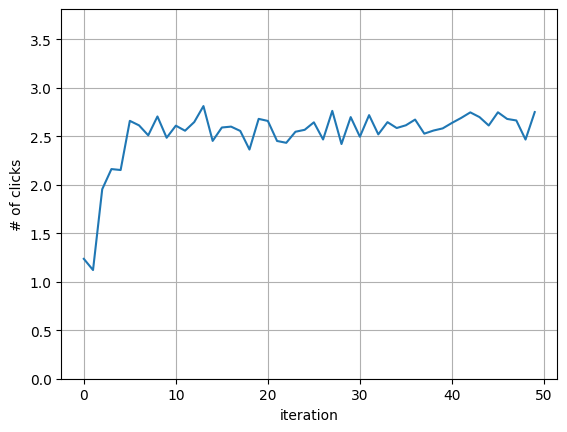

Iteration 49 finished in 33.826072216033936 sec.


In [26]:
metrics = []
for i in range(NUM_ITER):
    print(f'Iteration {i} started')
    iter_time = time.time()
    # выбираем пользователей, которые делают покупки на данной итерации
    current_users = sim.sample_users(0.1).cache()
    # получаем историю их взаимодействия с симулятором в прошлом
    log = sim.get_log(users)

    
    ### YOUR CODE HERE: порекомендуйте top-K товаров для каждого пользователя из current_users
    recs = model.predict(
        log=log,
        k=K,
        users=current_users,
        items=items,
        filter_seen_items=False
    ).cache()
    ###
    
    assert (recs
            .groupBy('user_idx')
            .agg(sf.count("item_idx").alias("num_items"))
            .filter(sf.col("num_items") == sf.lit(K))
            .count() 
            == 
            current_users.count()
           )
    
    # получаем отклики на рекомендации
    true_resp = sim.sample_responses(
        recs_df=recs,
        user_features=current_users,
        item_features=items,
        action_models=popularity_model
    ).cache()

    # записываем историю взаимодействия пользователей с рекомендательной системой на этой итерации
    sim.update_log(true_resp, iteration=i)

    # оцениваем качество. внутри цикла модель делает exploration, 
    # поэтому финальное качество может быть лучше после его отключения
    # пример оценки метрик с отключением exploration дан в задании 2
    metrics.append(calc_metric(true_resp))

   ### YOUR CODE HERE: дообучите рекомендательную модель на новых данных
    model.ucb._clear_cache()
    train_log = sim.log.cache()
    model.fit(
        log=train_log.select('user_idx', 'item_idx', 'response')\
                     .withColumnRenamed('response', 'relevance')
        )
    ###

    current_users.unpersist()
    if log is not None:
        log.unpersist()
    recs.unpersist()
    true_resp.unpersist()
    train_log.unpersist()

    plot_metric(metrics)
    print(f'Iteration {i} finished in {time.time() - iter_time} sec.')

Посмотреть на результаты работы модели и функции отлика на конкретной итерации можно в log-e симулятора

In [35]:
sim.log.filter(sf.col("__iter") == 1).show(2)

+--------+--------+--------------------+--------+------+
|item_idx|user_idx|           relevance|response|__iter|
+--------+--------+--------------------+--------+------+
|      79|      12|0.019447182985964064|       0|     1|
|      57|      12|0.015374348077430188|       0|     1|
+--------+--------+--------------------+--------+------+
only showing top 2 rows



## Финальный результат

In [27]:
### YOUR CODE HERE: порекомендуйте top-K товаров для каждого пользователя из current_users
# отключаем exploration модели
recs = model.predict(
    log=sim.log,
    k=K,
    users=users,
    items=items,
    filter_seen_items=False
).cache()
###

assert (recs
        .groupBy('user_idx')
        .agg(sf.count("item_idx").alias("num_items"))
        .filter(sf.col("num_items") == sf.lit(K))
        .count() == users.count()
       )

Сохраните ноутбук, ячейки в котором выполнены последовательно. Результаты из ячейки ниже будут использоваться для оценки решения команды. Свою модель приложите к ноутбуку в виде py-файла и импортируйте модель из него для всех трех заданий. 

In [28]:
# получаем отклики на рекомендации
true_resp = sim.sample_responses(
    recs_df=recs,
    user_features=users,
    item_features=items,
    action_models=popularity_model
).cache()

# оцениваем качество
print(f"Среднее число купленных товаров на пользователя после обучения модели = {calc_metric(true_resp)}")

Среднее число купленных товаров на пользователя после обучения модели = 2.647


In [38]:
recs.unpersist()
true_resp.unpersist()

DataFrame[item_idx: bigint, user_idx: bigint, relevance: double, response: int]